In [1]:
import jax
import jax.numpy as jnp
from jax import device_put, device_get
import jax.random as random
import numpy as np
import flax.linen as nn
import optax
from functools import partial, wraps
from typing import Any, NamedTuple,Callable, Iterable, Optional, Tuple, Union,Sequence
from optical_flax.utils import realize, normal_init, show_tree, tree_r2c, tree_c2r
from collections import namedtuple
from flax.core import freeze, unfreeze
from commplax.module import core
from commplax.module.core import SigTime, Signal, zeros, conv1d_t, vmap,wpartial,delta,gauss
import optical_flax.base as base
import optical_flax.layers as layers
import optax
import matplotlib.pyplot as plt
## Define datax
from gdbp import gdbp_base as gb, data as gdat, aux
data_train = gdat.load(1, 0, 4, 2)[0]
data_test = gdat.load(2, 0, 4, 2)[0]

In [3]:
## Training FDBP Model on a signal 
from commplax import optim 
lr = optim.piecewise_constant([500, 1000], [2e-5, 1e-5, 1e-6])
tx = optax.adam(learning_rate=lr)

## define model
batch_size = 500
sparams_flatkeys = []  # [('FDBP',),('RConv',)]
model = base.model_init(data_train,sparams_flatkeys=sparams_flatkeys)  
gen = base.train(model, data_train, batch_size=500, n_iter=2000, tx=tx)
loss0, Train0 = base.run_result(gen)

In [38]:
## Meta DBP :
from optical_flax.layers import MetaSSFM, GRU_DBP, fdbp
from commplax import optim 
lr = optim.piecewise_constant([500, 1000], [2e-5, 1e-5, 1e-6])
tx = optax.adam(learning_rate=lr)
sparams_flatkeys =   [] # [('DBP',),('RConv',)]
model = base.model_init(data_train,init_len = 1990, sparams_flatkeys=sparams_flatkeys,domain='frequency',GDBP=MetaSSFM, dtaps=1990, ntaps=1)  
gen = base.train(model, data_train, batch_size=500, n_iter=2000, tx=tx)
loss1, Train1 = base.run_result(gen)

In [41]:
## Meta DBP : 输入的Batch size 需要调整
from optical_flax.layers import MetaSSFM, GRU_DBP, fdbp
from commplax import optim 
lr = optim.piecewise_constant([500, 1000], [1e-4, 1e-5, 1e-6])
tx = optax.adam(learning_rate=lr)
sparams_flatkeys =  [('DBP',),('RConv',)] # [('DBP',),('RConv',)]
model = base.model_init(data_train,init_len = 1990, sparams_flatkeys=sparams_flatkeys,domain='frequency',GDBP=MetaSSFM, dtaps=1990, ntaps=1)  
gen = base.train(model, data_train, batch_size=500, n_iter=2000, tx=tx)
loss2, Train2 = base.run_result(gen)

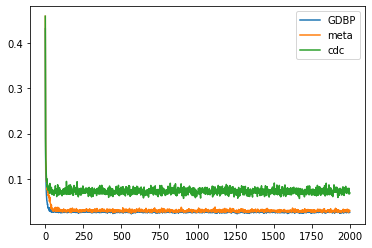

In [42]:
## plot
import matplotlib.pyplot as plt
plt.plot(loss0,label='GDBP')
plt.plot(loss1, label='meta')
plt.plot(loss2, label='cdc')
plt.legend(loc='best')

In [ ]:
## GRU DBP : 输入的Batch size 需要调整
from optical_flax.layers import MetaSSFM, GRU_DBP, fdbp
from commplax import optim 
lr = optim.piecewise_constant([500, 1000], [2e-5, 1e-5, 1e-6])
tx = optax.adam(learning_rate=lr)
sparams_flatkeys = []  # [('FDBP',),('RConv',)]
model = base.model_init(data_train,init_len = 2000, sparams_flatkeys=sparams_flatkeys,domain='time',GDBP=GRU_DBP ,dtaps=261, n_taps=1)  
gen = base.train(model, data_train, batch_size=500, n_iter=10, tx=tx)
loss2, Train2 = base.run_result(gen)

In [ ]:
### 可视化阶段性结果
import optical_flax.layers as layers
from commplax import plot as cplt

fdbp = realize(layers.fdbp())
params = Train1[-1].params['DBP']
y = core.Signal(data_train.y[1000:2990])

key = random.PRNGKey(0)
init_p = fdbp.init(key, y)
z = fdbp.apply({'const':init_p['const'], 'params':params}, y)

cplt.scatter(y.val)
cplt.scatter(z.val)

DeviceArray(0.07536945, dtype=float32)

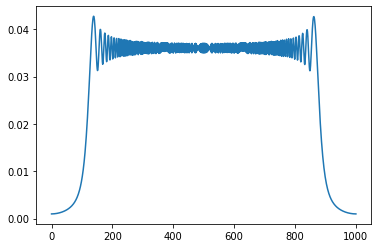

In [44]:
## Data Loading test
import matplotlib.pyplot as plt
n_batch, batch_gen = gb.get_train_batch(data_train, batchsize=500, overlaps=model.overlaps,sps=2) 
for (y, x) in batch_gen:
    break

## dbp_params  Time domian dispersion kernel
from commplax import comm
a = data_train.a
h,phi = comm.dbp_params(a['samplerate'], a['distance'] / a['spans'],a['spans'], 1001,
            a['lpdbm'] - 3, 
            virtual_spans=1,
            ignore_beta3=False)

ifft = jnp.fft.ifft
fft = jnp.fft.fft
h0 = h[0,:,1]
plt.plot(jnp.abs(h0))


from optical_flax.initializers import fdbp_init
d_init, n_init = fdbp_init(data_train.a, steps=3)
key = random.PRNGKey(0)
jnp.sum(n_init(key, (3,)))

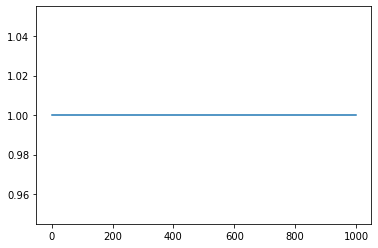

In [80]:
from optical_flax.dsp import linFiberCh
from optical_flax.core import parameters
linearChannel = False
paramCh = parameters()
paramCh.D = 16.5       # ps/nm/km
paramCh.Fc = 193.4e12  # Hz
paramCh.hz =  10      # km
paramCh.gamma = 1.3174420805376552    # 1/(W.km)
paramCh.amp = 'edfa'
_,H = linFiberCh(np.zeros(1001), a['distance'], 0, paramCh.D, paramCh.Fc, a['samplerate']/1e3)
plt.plot(np.abs(ifft(H)))


In [60]:
## 信号处理基础
fft = np.fft.fft
ifft = np.fft.ifft
shift = np.fft.fftshift
freq = np.fft.fftfreq

2.454525295374541e-12


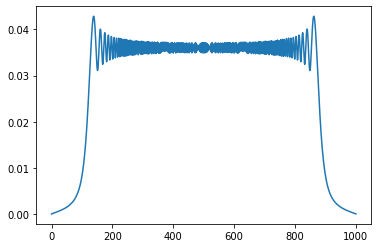

In [84]:
## dispersion operator
N = 1001
h = 1/a['samplerate']
w = 2 * np.pi *np.fft.fftfreq(N, h) # ifftshifted  w的范围不会随着 N 改变

B_2   = -2.1044895291667397e-26
dz = 375000.0*3
C = B_2 / 2 * dz 
H   = np.exp(-1j * C * w**2)

delay   = (N - 1) // 2
H_casual = H * np.exp(-1j * w * delay * h) ## 频域相位旋转等价于时域平移，将时域对齐
h_casual = ifft(H_casual)
h1 = shift(ifft(H))

plt.plot(np.abs(h1))
print(np.sum(np.abs(h1-h_casual)))

In [85]:
import scipy.constants as const
N = 1001
D =  paramCh.D
Fc = paramCh.Fc
Fs = a['samplerate']
alpha = 0
L = a['distance']/1e3
c_kms = const.c/1e3
λ  = c_kms/Fc
α  = alpha/(10*np.log10(np.exp(1)))
beta2 = -(D*λ**2)/(2*np.pi*c_kms)

omega = 2*np.pi*Fs * freq(N)
H1 = np.exp(-α*L - 1j*(beta2/2)*(omega**2)*L)


array([0.00000000e+00+0.00000000e+00j, 8.76018036e-10-3.62287854e-07j,
       1.40160831e-08-1.44908787e-06j, ...,
       7.09519260e-08-3.25982816e-06j, 1.40160831e-08-1.44908787e-06j,
       8.76018036e-10-3.62287854e-07j])

/Users/xinyu/opt/anaconda3/envs/commplax/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


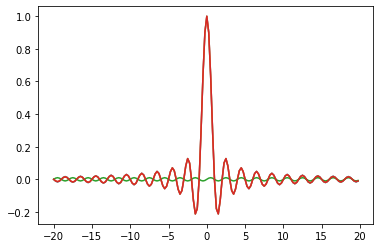

In [57]:
### FFT 做频谱分析
N = 400
h = 0.01
t = np.linspace(-0.5 * N*h,0.5*N*h,N)
x = (np.abs(t) < 0.5)*1.0
f = freq(N, h)
omega = 2*np.pi*f
xf = fft(shift(x))*h   # 使用fft计算离散信号的频谱 (需要shift 因为fft默认信号时间从0开始)

fs = shift(f)
xfs = shift(xf)

d = int(0.5*N- 20 * N * h)   ## 展示 【-20,20】Hz
plt.plot(fs[d:-d],np.sinc(fs)[d:-d])
plt.plot(fs[d:-d],xfs[d:-d])
plt.plot(fs[d:-d],xfs.imag[d:-d])
plt.plot(fs[d:-d],xfs.real[d:-d])